# Mixed Variable Types

``Golem`` can handle continuous, discrete, and categorical variables. Here we show a couple of examples with uncertain discrete and categorical variables.

Note that when using categorical variables, the argument ``X`` for the ``predict`` method *has* to be a pandas ``DataFrame``, rather than a numpy array.

In [1]:
from golem import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(context='talk', style='ticks')

Let's define two objective functions:

* ``objective_discrete`` takes two inputs, where the second one is expected to be an integer;

* ``objective_categorical`` takes three inputs, where the third one is categorical, either ``A`` or ``B``.

In [2]:
def objective_discrete(x0, x1):
    # x0 is continuous
    # x1 is discrete, {0, 1, 2, 3, 4, 5}
    fx0 = 10 / (1 + 0.3 * np.exp(6 * x0)) + 0.1 * np.abs(2 * x0**2)
    
    x1 = np.round(X1, 0)
    fx1 = 10 / (1 + 0.3 * np.exp(6 * x1)) + 0.1 * np.abs(2 * x1**2)
    
    return fx0 + fx1

def objective_categorical(x0, x1, category):
    if category == 'A':
        fx0 = 10 / (1 + 0.3 * np.exp(6 * x0)) + 0.1 * np.abs(2 * x0**2)
        fx1 = 10 / (1 + 0.3 * np.exp(6 * x1)) + 0.1 * np.abs(2 * x1**2)
        return fx0 + fx1
    elif category == 'B':
        x0 = 5 - x0
        x1 = 5 - x1
        fx0 = 10 / (1 + 0.3 * np.exp(6 * x0)) + 0.1 * np.abs(2 * x0**2)
        fx1 = 10 / (1 + 0.3 * np.exp(6 * x1)) + 0.1 * np.abs(2 * x1**2)
        return fx0 + fx1 + 5
    else:
        raise ValueError

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu_r'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha)
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    # mark minima
    ax.scatter([X0.flatten()[np.argmin(y)]], [X1.flatten()[np.argmin(y)]], 
            s=200, color='white', linewidth=1, edgecolor='k', marker='*', zorder=20)
        
    ax.set_aspect('equal', 'box')
    return mappable

## Discrete variables

Let's plot the objective function.

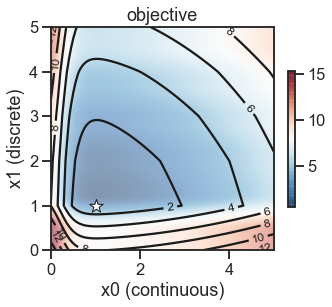

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

x0 = np.linspace(0, 5, 100)
x1 = np.arange(0,6)
X0, X1 = np.meshgrid(x0, x1)
Y = objective_discrete(X0, X1)

_ = plot_contour(ax, X0, X1, Y, [0, 5], [0, 5], cbar=True)
_ = ax.set_xlabel('x0 (continuous)')
_ = ax.set_ylabel('x1 (discrete)')
_ = ax.set_title('objective')

Then, we can use a discrete probability distribution, like ``DiscreteLaplace`` or ``Poisson``, to model the uncertainty in the discrete variable ``x1``.

[INFO] Golem ... 1 tree(s) parsed in 39.77 ms ...
[INFO] Golem ... Convolution of 600 samples performed in 54.73 ms ...


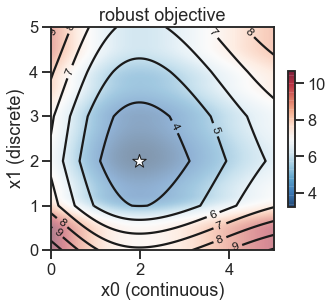

In [4]:
distributions = [Normal(std=1), DiscreteLaplace(scale=1)]

# put data into a pandas dataframe
Xy = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'y': Y.flatten()})
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1:]

# compute the robust objective
golem = Golem(ntrees=1, random_state=42, nproc=1)
golem.fit(X=X, y=y)
y_robust = golem.predict(X=X, distributions=distributions)
Y_robust = np.reshape(y_robust, newshape=np.shape(X0))

# plot robust surface
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
_ = plot_contour(ax, X0, X1, Y_robust, [0, 5], [0, 5], cbar=True)
_ = ax.set_xlabel('x0 (continuous)')
_ = ax.set_ylabel('x1 (discrete)')
_ = ax.set_title('robust objective')

## Categorical variables

Here we plot the objective function that depends on two continuous and one categorical parameter.

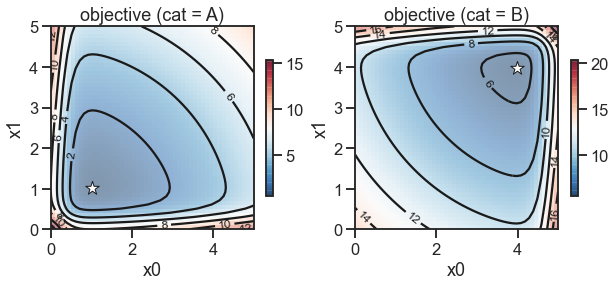

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

x0 = np.linspace(0, 5, 50)
x1 = np.linspace(0, 5, 50)
X0, X1 = np.meshgrid(x0, x1)
YA = objective_categorical(X0, X1, 'A')
YB = objective_categorical(X0, X1, 'B')

_ = plot_contour(ax1, X0, X1, YA, [0, 5], [0, 5], cbar=True)
_ = ax1.set_xlabel('x0')
_ = ax1.set_ylabel('x1')
_ = ax1.set_title('objective (cat = A)')

_ = plot_contour(ax2, X0, X1, YB, [0, 5], [0, 5], cbar=True)
_ = ax2.set_xlabel('x0')
_ = ax2.set_ylabel('x1')
_ = ax2.set_title('objective (cat = B)')

To model uncertainty in the categorical variable, **Golem** supports a simple ``Categorical`` distribution where the probability mass specified is distributed from the queried categorical option to all other options. In the example below we assume that the two contonuous variables (``x0`` and ``x1``) have no uncertainty, while the categorical variable has an uncertainty of 0.2, which means that the robust objective for specific input values of ``x0`` and ``x1`` will be a weighted average of the objective where the queried category will have weight of 0.8 and the other, remaining, one will have a weight of 0.2.

[INFO] Golem ... 1 tree(s) parsed in 760.01 ms ...
[INFO] Golem ... Convolution of 5000 samples performed in 895.64 ms ...


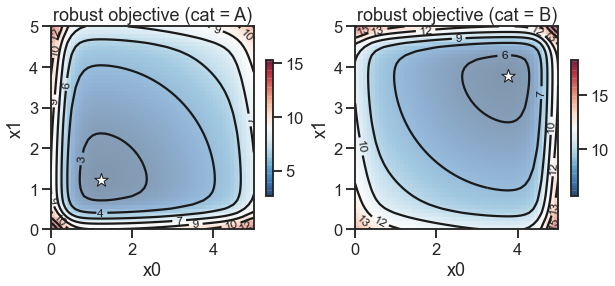

In [6]:
# `distributions` can be a dictionary or also a simple list in which the order of the distributions matches correctly
#  the order of the columns in `X` argument for the `predict` method

distributions = {'x0': Delta(),  # x0 variable (no uncertainty)
                 'x1': Delta(),  # x1 variable (no uncertainty)
                 'cat': Categorical(categories=['A','B'], unc=0.2) # cat variable
                }

# put data into a pandas dataframe
XyA = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'cat':['A']*len(X0.flatten()), 'y': YA.flatten()})
XyB = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'cat':['B']*len(X0.flatten()), 'y': YB.flatten()})
Xy = pd.concat([XyA, XyB])
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1:]

# compute the robust objective
golem = Golem(ntrees=1, random_state=42, nproc=1)
golem.fit(X=X, y=y)

y_robust = golem.predict(X=X, distributions=distributions)

yA_robust = y_robust[:2500]
yB_robust = y_robust[2500:]
YA_robust = np.reshape(yA_robust, newshape=np.shape(X0))
YB_robust = np.reshape(yB_robust, newshape=np.shape(X0))

# plot robust surface
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = plot_contour(ax1, X0, X1, YA_robust, [0, 5], [0, 5], cbar=True)
_ = ax1.set_xlabel('x0')
_ = ax1.set_ylabel('x1')
_ = ax1.set_title('robust objective (cat = A)')

_ = plot_contour(ax2, X0, X1, YB_robust, [0, 5], [0, 5], cbar=True)
_ = ax2.set_xlabel('x0')
_ = ax2.set_ylabel('x1')
_ = ax2.set_title('robust objective (cat = B)')

In the next example, we assume that also ``x0`` and ``x1`` are uncertain.

[INFO] Golem ... Convolution of 5000 samples performed in 3.36 s ...


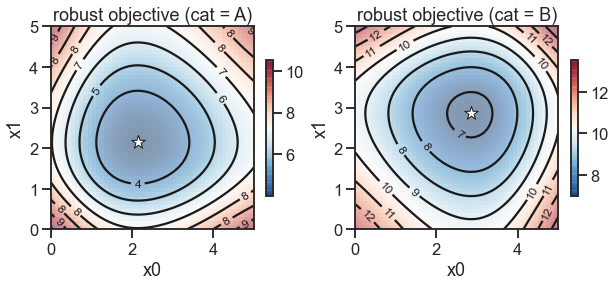

In [7]:
distributions = [Normal(std=1), Normal(std=1), Categorical(categories=['A','B'], unc=0.2)]

# predict
y_robust = golem.predict(X=X, distributions=distributions)

yA_robust = y_robust[:2500]
yB_robust = y_robust[2500:]
YA_robust = np.reshape(yA_robust, newshape=np.shape(X0))
YB_robust = np.reshape(yB_robust, newshape=np.shape(X0))

# plot robust surface
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = plot_contour(ax1, X0, X1, YA_robust, [0, 5], [0, 5], cbar=True)
_ = ax1.set_xlabel('x0')
_ = ax1.set_ylabel('x1')
_ = ax1.set_title('robust objective (cat = A)')

_ = plot_contour(ax2, X0, X1, YB_robust, [0, 5], [0, 5], cbar=True)
_ = ax2.set_xlabel('x0')
_ = ax2.set_ylabel('x1')
_ = ax2.set_title('robust objective (cat = B)')

In this case, as we have a categorical variable with only 2 options, if we set the argument ``unc`` to ``0.5``, we are effectively averaging the objective between the two categories, such that the robust objective for category A and B are equal.

[INFO] Golem ... Convolution of 5000 samples performed in 3.34 s ...


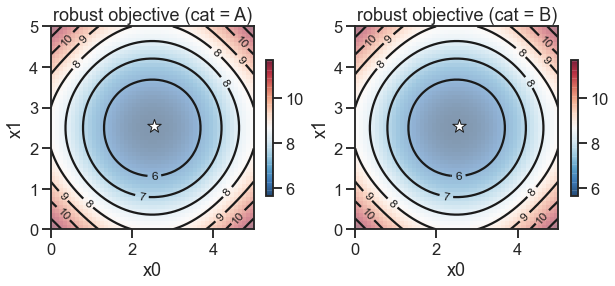

In [8]:
distributions = [Normal(std=1), Normal(std=1), Categorical(categories=['A','B'], unc=0.5)]

# predict
y_robust = golem.predict(X=X, distributions=distributions)

yA_robust = y_robust[:2500]
yB_robust = y_robust[2500:]
YA_robust = np.reshape(yA_robust, newshape=np.shape(X0))
YB_robust = np.reshape(yB_robust, newshape=np.shape(X0))

# plot robust surface
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = plot_contour(ax1, X0, X1, YA_robust, [0, 5], [0, 5], cbar=True)
_ = ax1.set_xlabel('x0')
_ = ax1.set_ylabel('x1')
_ = ax1.set_title('robust objective (cat = A)')

_ = plot_contour(ax2, X0, X1, YB_robust, [0, 5], [0, 5], cbar=True)
_ = ax2.set_xlabel('x0')
_ = ax2.set_ylabel('x1')
_ = ax2.set_title('robust objective (cat = B)')